#About the Paper
Supervised training is the dominant paradigm for image classifications, but curating large, labeled image datasets is both expensive and time consuming.The paper proposes Generative pre-training as an alternative. The Generative pre-training approach uses two steps. First of all, the model is trained via unsupervised learning based on vast amounts of data. The second part is using a target data set to fine tune the model from the previous step via supervised learning. Open AI released the Generative Pre Training model(GPT). which achieved the state of the art model in many NLP tasks. We try to replicate the same success for images. 


#Architecture

Using a Transformer architecture(Vaswani et al., 2017), a tractable and efficient likelihood based training objective, (Larochelle & Murray, 2011; Oord et al., 2016), generative pre-training for images performs at par with other self-supervised approaches. Our goal is to learn general purpose representations from the much larger set of available unlabeled images, and then use fine tuning/linear probing for classification.  We use [generative pretraining from pixels](https://cdn.openai.com/papers/Generative_Pretraining_from_Pixels_V1_ICML.pdf) (Mark Chen et.al.,2020) model to use that in classification task. The model is pretrained using pixel data i.e. given a sequence of pixels it has to autoregressively predict the next pixel in the sequence. While doing this prediction, it learns the feature representation of the image to help it better predict the pixel. We use the feature encoding to train a simple classifier for CIFAR 10.

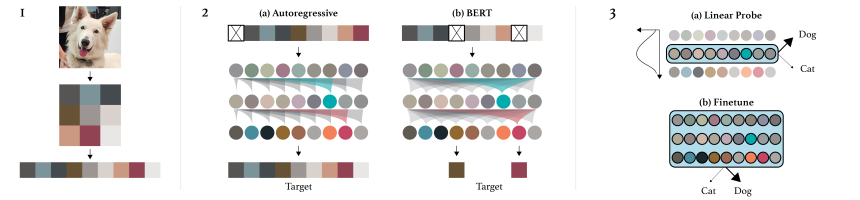
(

Image reference : Generative pretraining from pixels(Mark Chen et.al.,2020)

In [ ]:
import torch
from torch import nn
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
import os
import copy
import torch.utils.data as data_utils


device = 'cuda' if torch.cuda.is_available() else 'cpu'
if torch.cuda.is_available():
  print(torch.cuda.get_device_name(torch.cuda.current_device()))


#Data Loading Cell

In [ ]:
data_dir = "./cifar"
transform = transforms.Compose([
        transforms.ToTensor(),
    ])
batch_size=1

trainset_cifar10 = torchvision.datasets.CIFAR10(
    root=data_dir, train=True, download=True, transform=transform)

testset_cifar10 = torchvision.datasets.CIFAR10(
    root=data_dir, train=False, download=True, transform=transform)
indices = torch.arange(500)
train_small = data_utils.Subset(trainset_cifar10, indices)
test_small=data_utils.Subset(testset_cifar10, indices)
trainset_cifar10, validset_cifar10 = torch.utils.data.random_split(train_small, [400, 100])

trainloader_cifar10 = torch.utils.data.DataLoader(trainset_cifar10, batch_size=batch_size, shuffle=True, num_workers=2)
validloader_cifar10 = torch.utils.data.DataLoader(validset_cifar10, batch_size=batch_size, shuffle=True, num_workers=2)
testloader_cifar10 = torch.utils.data.DataLoader(testset_cifar10, batch_size=batch_size, shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
fig2, axes2 = plt.subplots(8,8,figsize=(8,8))
i=0
for inputs,labels in train_small:
  #print(math.floor(i/12),i%12)
  axes2[math.floor(i/12)][i%12].set_axis_off()
  axes2[math.floor(i/12)][i%12].imshow(transforms.ToPILImage()(inputs))
  i=i+1
  if i>63:break

In [ ]:
!pip install huggingface-hub
!pip install tokenizers
!pip install transformers

Here we import the iGPT - small model which is pretrained. This model like a language model takes as input an encoding. The feature extractor,(also pretrained) encodes any image into 32x32 encoding sequence using vocab size 512.

In [ ]:
#importing pretrained model from hf
from transformers import ImageGPTFeatureExtractor, ImageGPTModel
from PIL import Image
import requests


feature_extractor = ImageGPTFeatureExtractor.from_pretrained("openai/imagegpt-small")
model = ImageGPTModel.from_pretrained("openai/imagegpt-small")
model.to(device)
model.requires_grad_(requires_grad=False)



In [ ]:
# for testing output cells
for i, data in enumerate(trainloader_cifar10, 0):
  inputs, labels=data
  inputs,labels=inputs.to(device),labels.to(device)
  input = feature_extractor(images=inputs[0], return_tensors="pt")
  display(input)
  outputs = model(**input)
  last_hidden_states = outputs.last_hidden_state
  print(last_hidden_states.shape)
  print(outputs.hidden_states)
  break

Here we precompute final layer encodings of the input images and store them to then train the predictor using these encodings as outputs.This is the most time taking step. It takes around 4-5 sec for each image. Since here we run for 500 images, it would take about 40 mins. But then we don't have to run the huge iGPT model during training so saves lots of time.


last_hidden_state gives a [1,1024,512] i.e [batch_size,n_pos,n_emb] matrix but we average over the sequence to get final values for the emmbedings.

In [ ]:
output_list=[]
i=0
for inputs, label in train_small:
  i=i+1
  print(i)
  features = feature_extractor(images=inputs, return_tensors="pt")
  output = model(**features)
  last_hidden_states=output.last_hidden_state
  h=torch.mean(last_hidden_states,dim=1)
  output_list.append((h,label))

Using the output list, we split it into 2 sets one for training and validation and one for testing.

In [ ]:
trainvalidset_cifar10, testset_cifar10 = torch.utils.data.random_split(output_list, [450,50])

In [ ]:
testloader_cifar10 = torch.utils.data.DataLoader(testset_cifar10, batch_size=batch_size, shuffle=False, num_workers=2)

We then split the set for training and validation into their individual sets. Repeating below step after every 50 epochs, model will get to train on previously untrained data but it improves the performance on previously unseen data as well. Although it is not exactly cross validation, this idea was inspired by cross validation. 

In [ ]:

trainset_cifar10, validset_cifar10  = torch.utils.data.random_split(trainvalidset_cifar10, [400, 50])
trainloader_cifar10 = torch.utils.data.DataLoader(trainset_cifar10, batch_size=32, shuffle=True, num_workers=2)
validloader_cifar10 = torch.utils.data.DataLoader(validset_cifar10, batch_size=32, shuffle=True, num_workers=2)

Next, we use 3 different types of neural networks for classification on the precomputed data :      


1.   Predictor with 1 linear hidden layer
2.   Predictor with 2 linear hidden layers
3.   Predictor with no hidden layers 



#Predictor with 1 linear hidden layer

In [ ]:
class Predictor1(torch.nn.Module):

  def __init__(self):
    super().__init__()
    self.layers = torch.nn.Sequential(
        nn.Linear(512,128),
        nn.Dropout(0.6),
        nn.ReLU(),
        nn.Linear(128,10),
        nn.LogSoftmax(dim=1),

    )

  def forward(self, x):
    x = self.layers(x)
    return x

#Predictor with 2 linear hidden layers

In [ ]:
class Predictor2(torch.nn.Module):

  def __init__(self):
    super().__init__()
    self.layers = torch.nn.Sequential(
        nn.Linear(512,128),
        nn.Dropout(0.6),
        nn.ReLU(),
        nn.Linear(128,32),
        nn.Dropout(0.6),
        nn.ReLU(),
        nn.Linear(32,10),
        nn.LogSoftmax(dim=1),

    )

  def forward(self, x):
    x = self.layers(x)
    return x

#Predictor with no hidden layers

In [ ]:
class LinearReg(torch.nn.Module):

  def __init__(self):
    super().__init__()
    self.layers = torch.nn.Sequential(
        nn.Linear(512,10),
        nn.LogSoftmax(dim=1)

    )

  def forward(self, x):
    x = self.layers(x)
    return x

In [ ]:
# testing output shape
test_input = torch.randn(1,3,32,32).to(device) # 100 examples each of shape 28*28
input = feature_extractor(images=test_input[0], return_tensors="pt")
outputs = model(**input)
last_hidden_states = outputs.last_hidden_state

pred=pred_model(last_hidden_states)
h=torch.mean(last_hidden_states,dim=1)
pred1=torch.matmul(h,wclf.T)
print(pred)
print(pred1)

In [ ]:
#testing output shape
for i, data in enumerate(trainloader_cifar10,0):
  inputs,labels=data
  inputs,labels=inputs.to(device),labels.to(device)
  pred=pred_model(inputs[:,0,:])
  print(pred.shape)

We first try training without precomputing. It took a lot of time to train with the kind of processing power at our hands, so we could not quantify it. 

#Training function without precomputing

In [ ]:
# training function without precomputing
training_loss_list = []
validation_loss_list = []
criterion2 = torch.nn.CrossEntropyLoss()
lr=0.01
batch_size=1
def train_cifar(pred_model,model):

  pred_model.train()

  # defining the optimizer
  optimizer = torch.optim.Adam(pred_model.parameters(), lr=lr)

  for epoch in range(5):

    train_loss = 0.0
    epoch_steps = 0

    for i, data in enumerate(trainloader_cifar10, 0):
          
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)
          # forward prop
          input = feature_extractor(images=inputs[0], return_tensors="pt")
          output = model(**input)
          last_hidden_states = output.last_hidden_state
          pred=pred_model(last_hidden_states)

          # loss calculation
          loss = criterion2(pred,labels)

          # backprop
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          # add up the losses
          train_loss += loss.item()
          print(train_loss/(i+1))
          training_loss_list.append(loss.item())
          epoch_steps += 1

  
    val_loss = 0.0
    val_steps = 0

    # finding the generalization error
    for i, data in enumerate(validloader_cifar10, 0):
        with torch.no_grad():
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            input = feature_extractor(images=inputs[0], return_tensors="pt")
            output = model(**input)
            last_hidden_states = output.last_hidden_state
            pred=pred_model(last_hidden_states)

            loss =criterion2(pred,labels)
            print(pred,labels)
            val_loss += loss.cpu().numpy()
            print(val_loss/(i+1))
            validation_loss_list.append(loss.item())
            val_steps += 1

    training_loss_list.append(train_loss/len(trainloader_cifar10))
    validation_loss_list.append(val_loss/len(validloader_cifar10))

    print(f"Epoch {epoch+1} training loss = {train_loss/len(trainloader_cifar10):.4f} validation loss: {val_loss/len(validloader_cifar10):.4f}")



  # plotting the training process
  plt.plot(training_loss_list, 'r', label = 'Training Loss')
  plt.plot(validation_loss_list, 'g', label = 'Validation Loss')
  plt.legend()
  plt.show()

Training function using precomputed outputs significantly reduces the training time because for every epoch the iGPT model does not have to be recalled. 

#Training function using precomputed outputs

In [ ]:
#training function using precomputed outputs
training_loss_list = []
validation_loss_list = []
criterion2 = torch.nn.CrossEntropyLoss()
def train_cifar(pred_model,lr):

  pred_model.train()

  # defining the optimizer
  optimizer = torch.optim.Adam(pred_model.parameters(), lr=lr)

  for epoch in range(50):

    train_loss = 0.0
    epoch_steps = 0

    for i, data in enumerate(trainloader_cifar10, 0):
          
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)
          # forward prop
          #print(inputs.shape)
          pred=pred_model(inputs[:,0,:])

          # loss calculation
          loss = criterion2(pred,labels)

          # backprop
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          # add up the losses
          train_loss += loss.item()
          epoch_steps += 1

  
    val_loss = 0.0
    val_steps = 0

    # finding the generalization error
    for i, data in enumerate(validloader_cifar10, 0):
        with torch.no_grad():
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            pred=pred_model(inputs[:,0,:])

            loss =criterion2(pred,labels)
            val_loss += loss.cpu().numpy()
            val_steps += 1

    training_loss_list.append(train_loss/len(trainloader_cifar10))
    validation_loss_list.append(val_loss/len(validloader_cifar10))

    print(f"Epoch {epoch+1} training loss = {train_loss/len(trainloader_cifar10):.4f} validation loss: {val_loss/len(validloader_cifar10):.4f}")



  # plotting the training process
  plt.plot(training_loss_list, 'r', label = 'Training Loss')
  plt.plot(validation_loss_list, 'g', label = 'Validation Loss')
  plt.legend()
  plt.show()

In [ ]:
training_loss_list = []
validation_loss_list = []

In [ ]:
pred_model=Predictor1()

Epoch 1 training loss = 0.1347 validation loss: 0.2004
Epoch 2 training loss = 0.1548 validation loss: 0.1347
Epoch 3 training loss = 0.1184 validation loss: 0.1004
Epoch 4 training loss = 0.1228 validation loss: 0.1699
Epoch 5 training loss = 0.1106 validation loss: 0.2058
Epoch 6 training loss = 0.1341 validation loss: 0.1581
Epoch 7 training loss = 0.1408 validation loss: 0.2561
Epoch 8 training loss = 0.1216 validation loss: 0.1805
Epoch 9 training loss = 0.1413 validation loss: 0.2154
Epoch 10 training loss = 0.1193 validation loss: 0.1788
Epoch 11 training loss = 0.1150 validation loss: 0.2069
Epoch 12 training loss = 0.1152 validation loss: 0.1608
Epoch 13 training loss = 0.1124 validation loss: 0.2144
Epoch 14 training loss = 0.1257 validation loss: 0.1282
Epoch 15 training loss = 0.1271 validation loss: 0.1388
Epoch 16 training loss = 0.1127 validation loss: 0.1426
Epoch 17 training loss = 0.1089 validation loss: 0.1839
Epoch 18 training loss = 0.1301 validation loss: 0.1508
E

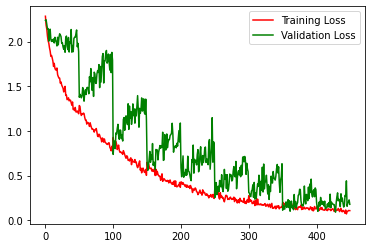

In [ ]:
train_cifar(pred_model,lr=0.001)

In [ ]:
pred_model2=Predictor2()

Epoch 1 training loss = 0.5661 validation loss: 0.8613
Epoch 2 training loss = 0.6071 validation loss: 0.7410
Epoch 3 training loss = 0.5820 validation loss: 0.8990
Epoch 4 training loss = 0.5516 validation loss: 0.7835
Epoch 5 training loss = 0.5752 validation loss: 0.9479
Epoch 6 training loss = 0.5932 validation loss: 0.6626
Epoch 7 training loss = 0.6543 validation loss: 0.5650
Epoch 8 training loss = 0.5296 validation loss: 0.7408
Epoch 9 training loss = 0.5969 validation loss: 0.8710
Epoch 10 training loss = 0.5593 validation loss: 0.7427
Epoch 11 training loss = 0.6038 validation loss: 0.8635
Epoch 12 training loss = 0.5865 validation loss: 0.7587
Epoch 13 training loss = 0.5880 validation loss: 0.9746
Epoch 14 training loss = 0.5567 validation loss: 0.7508
Epoch 15 training loss = 0.6354 validation loss: 0.7086
Epoch 16 training loss = 0.6100 validation loss: 0.9549
Epoch 17 training loss = 0.5555 validation loss: 0.9766
Epoch 18 training loss = 0.5077 validation loss: 0.9278
E

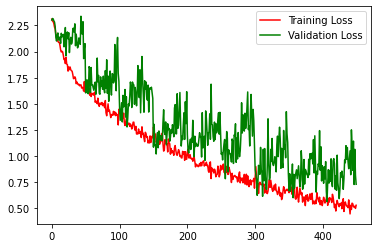

In [ ]:
train_cifar(pred_model2,lr=0.001)

In [ ]:
lin_model=LinearReg()

Epoch 1 training loss = 0.8429 validation loss: 0.7725
Epoch 2 training loss = 0.8225 validation loss: 0.7783
Epoch 3 training loss = 0.8128 validation loss: 0.7754
Epoch 4 training loss = 0.8006 validation loss: 0.7855
Epoch 5 training loss = 0.8149 validation loss: 0.7868
Epoch 6 training loss = 0.8022 validation loss: 0.8868
Epoch 7 training loss = 0.8053 validation loss: 0.8036
Epoch 8 training loss = 0.8019 validation loss: 0.8774
Epoch 9 training loss = 0.8005 validation loss: 0.9446
Epoch 10 training loss = 0.7869 validation loss: 0.8764
Epoch 11 training loss = 0.8005 validation loss: 0.8330
Epoch 12 training loss = 0.7931 validation loss: 0.8922
Epoch 13 training loss = 0.7891 validation loss: 0.8727
Epoch 14 training loss = 0.7895 validation loss: 0.9362
Epoch 15 training loss = 0.7998 validation loss: 0.8700
Epoch 16 training loss = 0.7809 validation loss: 0.9051
Epoch 17 training loss = 0.7965 validation loss: 0.9371
Epoch 18 training loss = 0.7787 validation loss: 0.8448
E

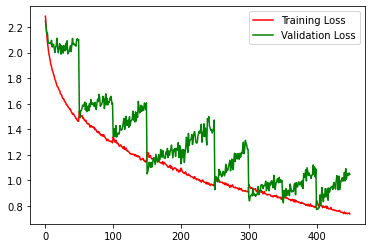

In [ ]:
train_cifar(lin_model,lr=0.001)

In [ ]:
acc=[]

#Testing on precomputed outputs

In [ ]:
#Testing on precomputed outputs
def test_cifar(pred_model):
  pred_model.eval()

  total = 0
  correct = 0
  val_loss = 0.0
  val_steps = 0
  for i, data in enumerate(testloader_cifar10,0):
    inputs,labels=data
    with torch.no_grad():
      if torch.cuda.is_available():
        inputs, labels = inputs.cuda(), labels.cuda()
      pred=pred_model(inputs[:,0,:])
      _, predicted = torch.max(pred.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      #print(predicted,labels)
      #print(correct,total)
  

      loss = criterion2(pred,labels)
      val_loss += loss.item()
      val_steps += 1

            
        


      # img=outputs[0]
      # plt.imshow(transforms.ToPILImage()(img))
      # img2=inputs[0]
      # plt.imshow(transforms.ToPILImage()(img2))
  acc.append((correct/total)*100)
  print("Accuracy = ", (correct/total)*100, '%')

In [ ]:
test_cifar(pred_model)

Accuracy =  92.0 %


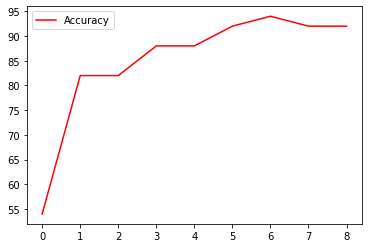

In [ ]:
plt.plot(acc, 'r', label = 'Accuracy')
plt.legend()
plt.show()

In [ ]:
test_cifar(pred_model2)

Accuracy =  90.0 %


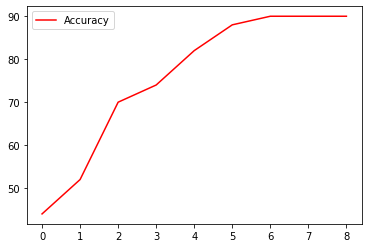

In [ ]:
plt.plot(acc, 'r', label = 'Accuracy')
plt.legend()
plt.show()

In [ ]:
test_cifar(lin_model)

Accuracy =  76.0 %


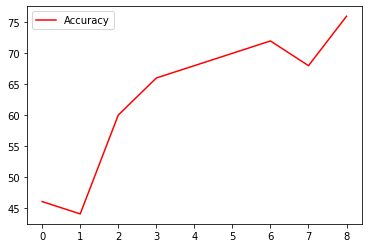

In [ ]:
plt.plot(acc, 'r', label = 'Accuracy')
plt.legend()
plt.show()

#Testing without precomputing

In [ ]:
#testing without precomputing
def test_cifar(pred_model,model):
  pred_model.eval()

  total = 0
  correct = 0
  val_loss = 0.0
  val_steps = 0
  for inputs, labels in testloader_cifar10:
    with torch.no_grad():
      if torch.cuda.is_available():
        inputs, labels = inputs.cuda(), labels.cuda()
      input = feature_extractor(images=inputs[0], return_tensors="pt")
      output = model(**input)
      last_hidden_states=output.last_hidden_state
      h=torch.mean(last_hidden_states,dim=1)
      pred=pred_model(h)
      _, predicted = torch.max(pred.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      print(predicted,labels)
      print(correct,total)
  

      loss = criterion2(pred,labels)
      val_loss += loss.item()
      val_steps += 1

            
        


      # img=outputs[0]
      # plt.imshow(transforms.ToPILImage()(img))
      # img2=inputs[0]
      # plt.imshow(transforms.ToPILImage()(img2))
  print("Accuracy = ", (correct/total)*100, '%')

Takes an indefinitely large amount of time, so results are not mentioned. 

In [ ]:
test_cifar(pred_model, model)